###### Livrable 2 – Mi-Parcours
## Préparation et Analyse Descriptive de Données

---

# 1. Chargement et exploration des données
*Cette étape permet de comprendre la structure initiale et de préparer le terrain pour le nettoyage.*

- Importation du dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    decimal='.',
    na_values='?',
    low_memory=False
)

In [6]:
df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'
)

- Aperçu des premières lignes

In [1166]:
df.head() 

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


# 2. Exploration des valeurs manquantes

## 2.1 Quantification

- Nombre de lignes où toutes les colonnes numériques sont manquantes

In [7]:
nbr_lgn_totalement_mqt = df[["Global_active_power","Global_reactive_power","Voltage",
                       "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]].isnull().all(axis=1).sum()

print("Nombre de lignes totalement manquantes :", nbr_lgn_totalement_mqt)

Nombre de lignes totalement manquantes : 25979


- Nombre de lignes où certaines colonnes sont manquantes mais pas toutes

In [8]:
nbr_lgn_partielement_mqt = df[[
    "Global_active_power","Global_reactive_power","Voltage", "Global_intensity","Sub_metering_1","Sub_metering_2",
    "Sub_metering_3"]].isnull().any(axis=1).sum() - nbr_lgn_totalement_mqt

print("Nombre de lignes avec valeurs manquantes isolées :", nbr_lgn_partielement_mqt)

Nombre de lignes avec valeurs manquantes isolées : 0


#### Il n'existe donc pas de valeur manquante isolee

### Un aperçu des valeurs manquantes

* Bloc de 891 lignes : 14 h 51 mn
* Bloc de 2027 lignes : 1 j 9 h 47 mn
* Bloc de 3129 lignes : 2 j 4 h 9 mn
* Bloc de 3305 lignes : 2 j 7 h 5 mn
* Bloc de 3723 lignes : 2 j 14 h 3 mn
* Bloc de 5237 lignes : 3 j 15 h 17 mn
* Bloc de 2027 lignes : 5 j 26 mn

In [9]:

is_na = df['Voltage'].isnull()

groups = (is_na != is_na.shift()).cumsum()

consecutive_counts = is_na.groupby(groups).cumsum()

nan_lengths = is_na.groupby(groups).sum()

result = nan_lengths[nan_lengths >= 1].to_list()

print("Tableau des blocs :",result)

somme = sum(x for x in result if x <= 10)
print("Somme des blocs <= 10 :", somme)

print("Somme des blocs :", sum(result))

Tableau des blocs : [2, 2, 1, 1, 2, 1, 3723, 1, 1, 1, 1, 3, 33, 2, 1, 83, 47, 1, 21, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 43, 6, 2, 1, 70, 1, 1, 38, 2, 24, 1, 1, 2, 1, 3, 3305, 4, 891, 1, 2, 1, 1, 2, 1, 3129, 1, 1, 1, 2027, 1, 1, 1, 1, 1, 7226, 5237, 1]
Somme des blocs <= 10 : 82
Somme des blocs : 25979


### Visualisation avant traitement des valeurs manquantes

## 2.2 Hypothese des causes

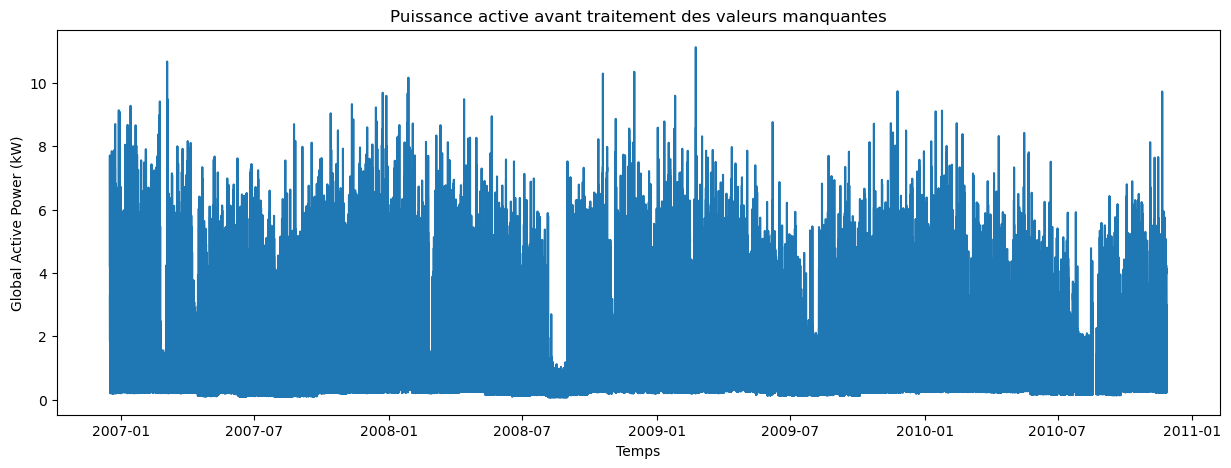

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df['DateTime'], df['Global_active_power'], label='Consommation')
plt.title('Puissance active avant traitement des valeurs manquantes')
plt.xlabel('Temps')
plt.ylabel('Global Active Power (kW)')
plt.show()

### Les blocs de taille courtes (entre 1–10)

 --> sont probablement du a des anomalies ponctuelles :

* des erreurs de transmission ou de saisie

* des interruptions temporaires (coupure de courant, bug capteur)

### Les blocs de taille longues (taille >10)

--> périodes entières sans mesure

*  souvent liées à panne prolongée

* appareil éteint ou une periode d'abscence (Vaccances)

## 2.3 Décision de traitement


### Interpoler  les petites plages de NaN (≤10 lignes) et supprimer toutes les longues plages (>10 lignes)

In [11]:
nbr_lgn_totalement_mqt = df[["Global_active_power","Global_reactive_power","Voltage",
                       "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]].isnull().all(axis=1).sum()
print("Nombre de lignes totalement manquantes :", nbr_lgn_totalement_mqt)

Nombre de lignes totalement manquantes : 25979


In [12]:
cols = ["Global_active_power","Global_reactive_power","Voltage",
        "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]
for col in cols:
    s = df[col]

    s = pd.to_numeric(s, errors='coerce')

    is_na = s.isna()
    groups = (is_na != is_na.shift()).cumsum()
    block_sizes = is_na.groupby(groups).sum()

    valid_blocks = block_sizes[block_sizes <= 10].index

    mask = is_na & groups.isin(valid_blocks)

    interpolated = s.copy()
    interpolated = interpolated.interpolate(method='linear')

    s.loc[mask] = interpolated.loc[mask]

    df[col] = s

In [13]:
nbr_lgn_totalement_mqt = df[["Global_active_power","Global_reactive_power","Voltage","Global_intensity",
                       "Sub_metering_1","Sub_metering_2","Sub_metering_3"]].isnull().all(axis=1).sum()
print("Nombre de lignes totalement manquantes :", nbr_lgn_totalement_mqt)

Nombre de lignes totalement manquantes : 25897


In [14]:
df = df.dropna()

In [15]:
nbr_lgn_totalement_mqt = df[["Global_active_power","Global_reactive_power","Voltage",
                       "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]].isnull().all(axis=1).sum()
print("Nombre de lignes totalement manquantes :", nbr_lgn_totalement_mqt)

Nombre de lignes totalement manquantes : 0


In [16]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64

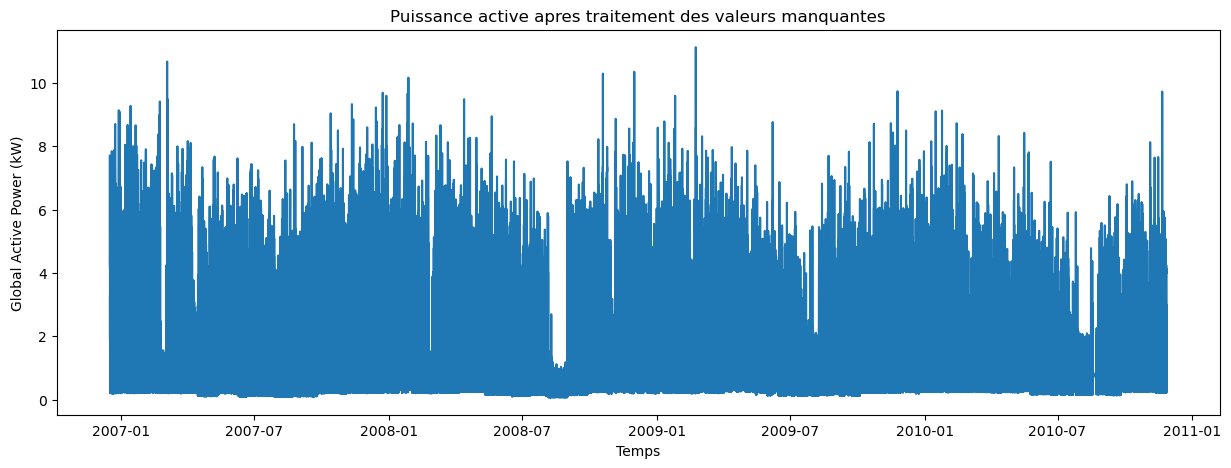

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['DateTime'], df['Global_active_power'], label='Consommation')
plt.title('Puissance active apres traitement des valeurs manquantes')
plt.xlabel('Temps')
plt.ylabel('Global Active Power (kW)')
plt.show()

### Taille restante du dataset

In [1178]:
print(df.size)

20493620


# 3. Exploration et traitement des valeurs aberrantes 
### 3.1 Définition des bornes normales


### Puissance active --> [0-12] kW
### Puissance réactive --> [0-1] kW
### Voltage --> [207–253] V
### Intensité --> [0-60] A
### Sous-compteurs --> [0-30] Wh/min

In [1179]:
df.describe().loc[['min','max']].round(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
min,0.08,0.00,223.20,0.2,0.0,0.0,0.0,2006-12-16 17:24:00
max,11.12,1.39,254.15,48.4,88.0,80.0,31.0,2010-11-26 21:02:00


### Verification des Types

In [1180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049362 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   DateTime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 172.0+ MB


### Conclusion : Pas de valeurs aberrante

# 4. Analyse les pics de consommation


ANALYSE : Global_active_power
Limite pour pics : 3.36
Pics détectés : 94925 (4.63%)
Min pic : 3.36
Max pic : 11.12


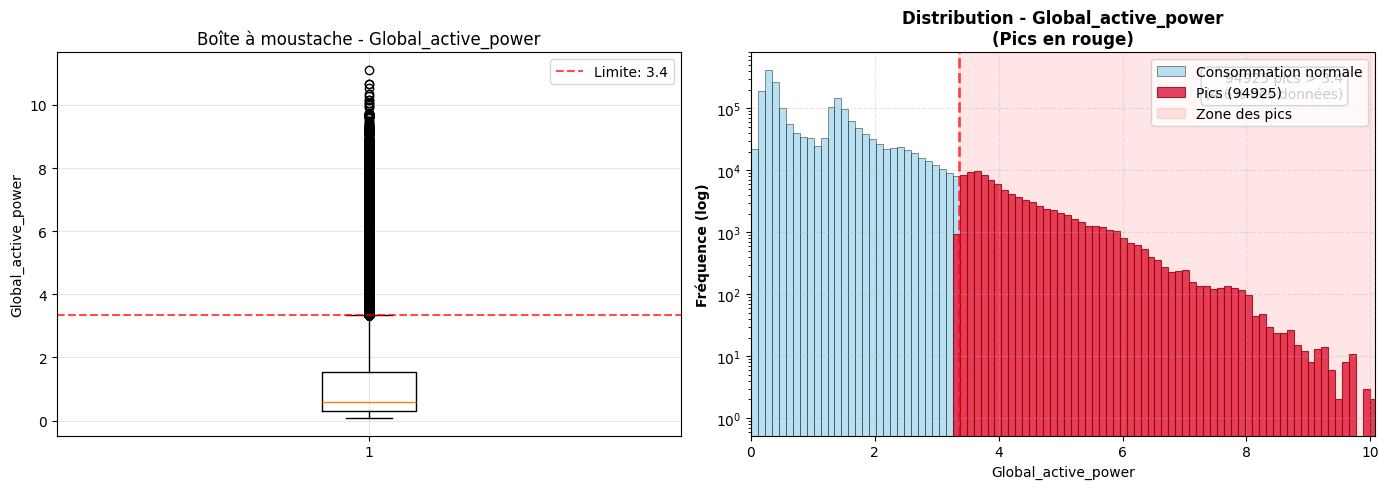


ANALYSE : Global_reactive_power
Limite pour pics : 0.41
Pics détectés : 40425 (1.97%)
Min pic : 0.41
Max pic : 1.39


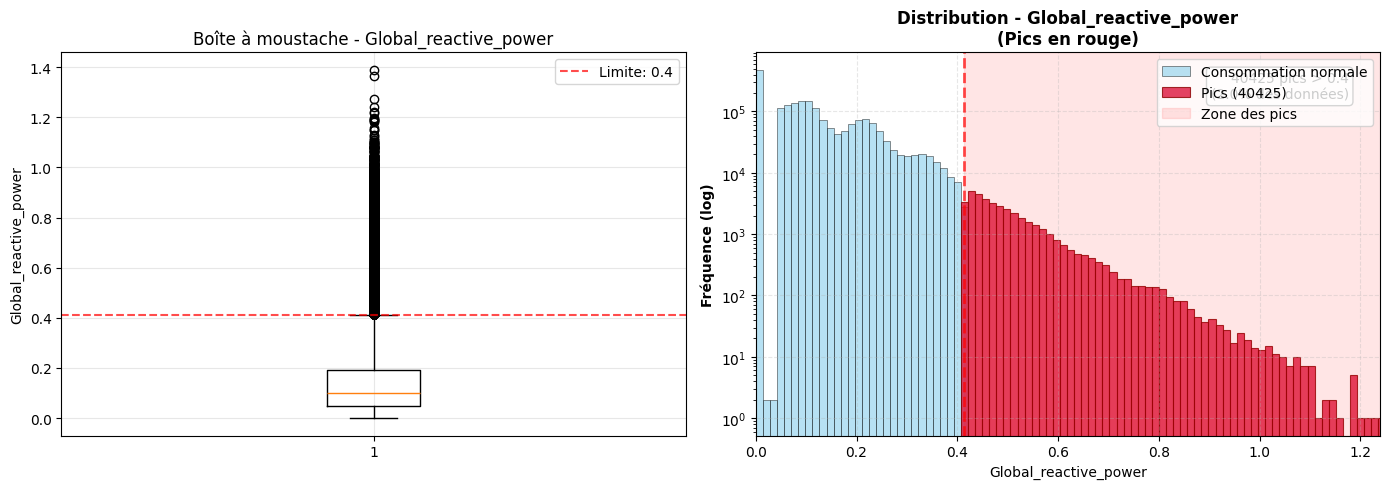


ANALYSE : Voltage
Limite pour pics : 248.74
Pics détectés : 13880 (0.68%)
Min pic : 248.74
Max pic : 254.15


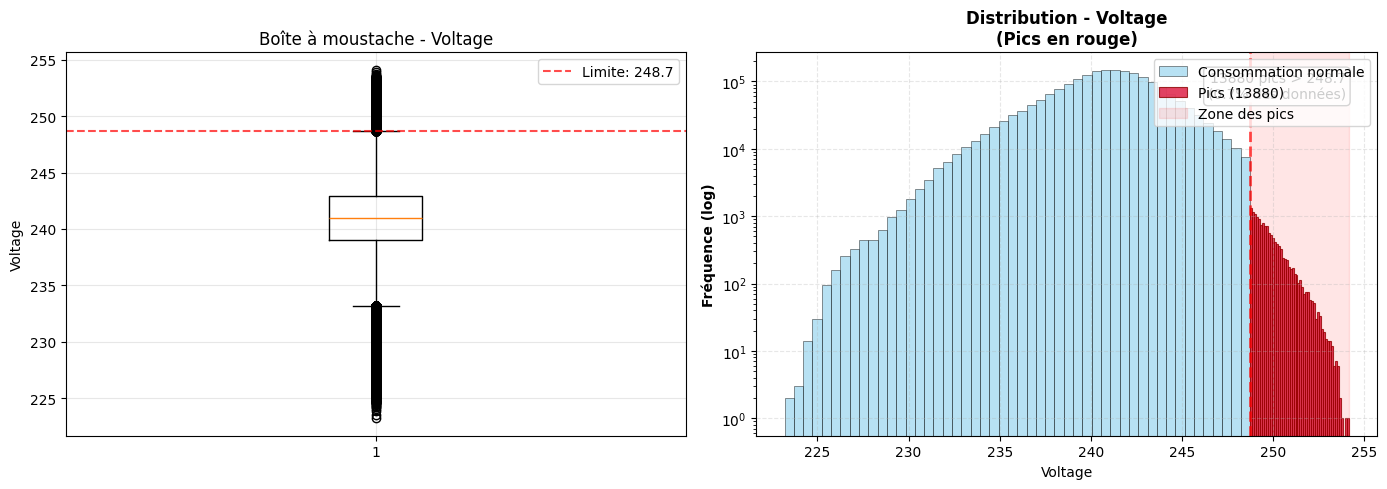


ANALYSE : Global_intensity
Limite pour pics : 13.90
Pics détectés : 100979 (4.93%)
Min pic : 14.00
Max pic : 48.40


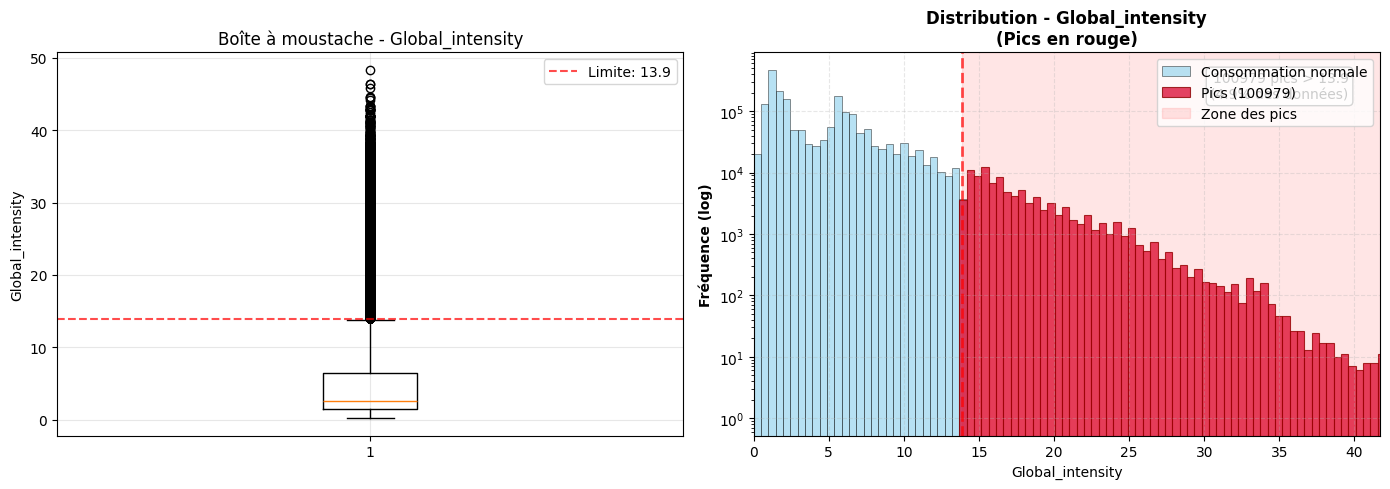


ANALYSE : Sub_metering_1
Limite pour pics : 0.00
Pics détectés : 169118 (8.25%)
Min pic : 0.50
Max pic : 88.00


/var/folders/t3/cqrzd8550sx8nvzlbd3fh03c0000gn/T/ipykernel_975/729342888.py:74: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[1].set_xlim([0, limite * 3])


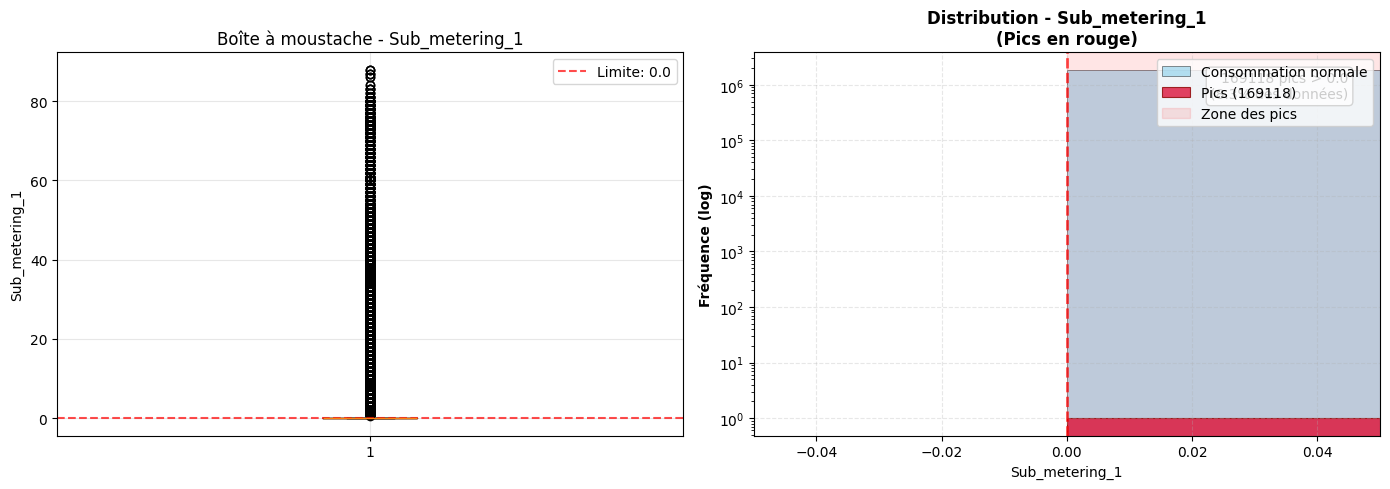


ANALYSE : Sub_metering_2
Limite pour pics : 2.50
Pics détectés : 77166 (3.77%)
Min pic : 3.00
Max pic : 80.00


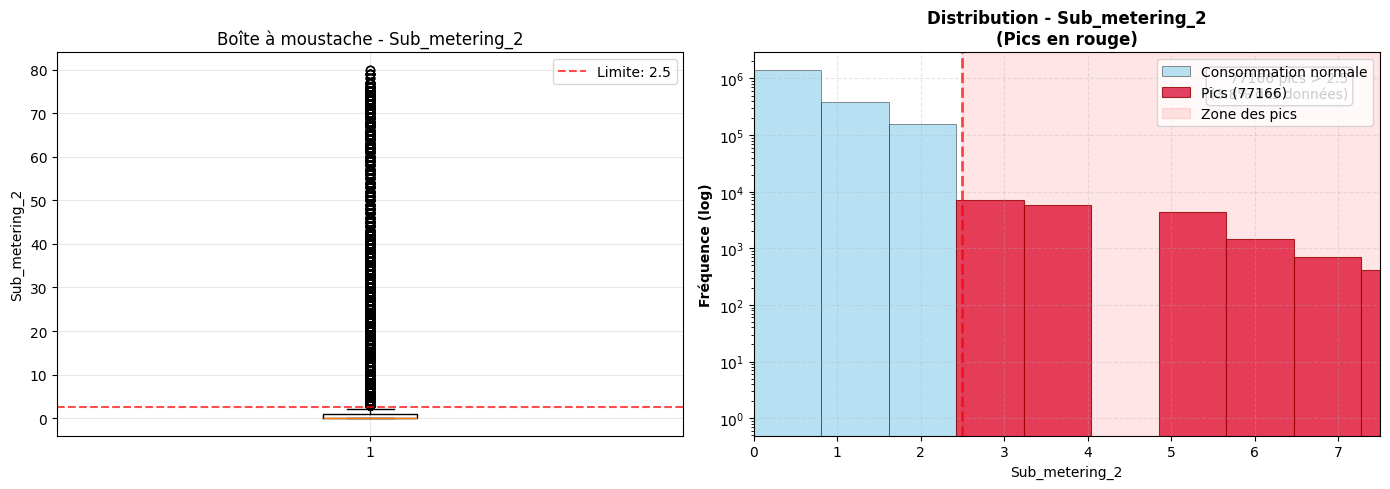


ANALYSE : Sub_metering_3
Limite pour pics : 42.50
Pics détectés : 0 (0.00%)


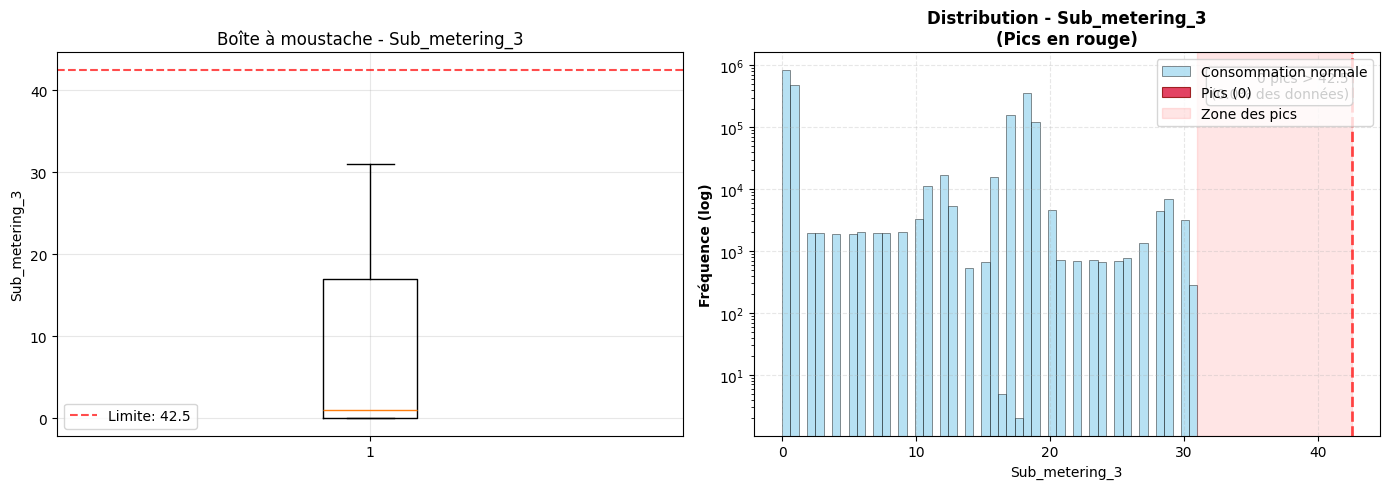

In [1181]:
def analyser_pics(serie):
    """Analyse les pics de consommation"""
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite = Q3 + 1.5 * IQR
    
    pics = serie[serie > limite]
    
    if len(pics) > 0:
        min_pic = pics.min()
        max_pic = pics.max()
    else:
        min_pic = max_pic = None
        
    return pics, limite, min_pic, max_pic

variables = ['Global_active_power', 'Global_reactive_power', 
             'Voltage', 'Global_intensity',
             'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for var in variables:
    print(f"\n{'='*50}")
    print(f"ANALYSE : {var}")
    print('='*50)
    
    pics, limite, min_pic, max_pic = analyser_pics(df[var].dropna())
    nb_pics = len(pics)
    total = len(df[var].dropna())
    
    print(f"Limite pour pics : {limite:.2f}")
    print(f"Pics détectés : {nb_pics} ({(nb_pics/total*100):.2f}%)")
    
    if min_pic is not None:
        print(f"Min pic : {min_pic:.2f}")
        print(f"Max pic : {max_pic:.2f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].boxplot(df[var].dropna())
    axes[0].axhline(y=limite, color='red', linestyle='--', alpha=0.7, label=f'Limite: {limite:.1f}')
    axes[0].set_title(f'Boîte à moustache - {var}')
    axes[0].set_ylabel(var)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    donnees_normales = df[var][df[var] <= limite]
    
    max_valeur = df[var].max()
    if max_valeur > limite * 2: 
        bins = np.linspace(0, max_valeur, 100)
    else:
        bins = 50 
    
    n_normal, bins_normal, _ = axes[1].hist(donnees_normales.dropna(), bins=bins, 
                                          alpha=0.6, label='Consommation normale', 
                                          color='skyblue', edgecolor='black', linewidth=0.5)
    
    n_pics, bins_pics, _ = axes[1].hist(pics, bins=bins, 
                                      alpha=0.8, label=f'Pics ({nb_pics})', 
                                      color='crimson', edgecolor='darkred', linewidth=0.8)
    
    axes[1].axvline(x=limite, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    axes[1].axvspan(limite, max_valeur, alpha=0.1, color='red', label='Zone des pics')
    
    axes[1].set_title(f'Distribution - {var}\n(Pics en rouge)', fontweight='bold')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Fréquence (log)', fontweight='bold')
    
    axes[1].set_yscale('log')
    
    if max_valeur > limite * 3:
        axes[1].set_xlim([0, limite * 3])
    
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3, linestyle='--')
    
    info_text = f'{nb_pics} pics > {limite:.1f}\n({(nb_pics/total*100):.1f}% des données)'
    axes[1].text(0.95, 0.95, info_text, transform=axes[1].transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 5. Analyse Descriptive des données

- Fusion des variable Date et Time afin de faciliter les analyses temporelle(tendance, periode et regroupement)

In [18]:
df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'
)

In [19]:
 df = df.set_index('DateTime')

In [20]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

In [21]:
df['Global_active_power_wh'] = df['Global_active_power'] * 1000 /60

### COURBE DE LA COMSOMMATION HORAIRE MOYENNE DE 2006 A 2010

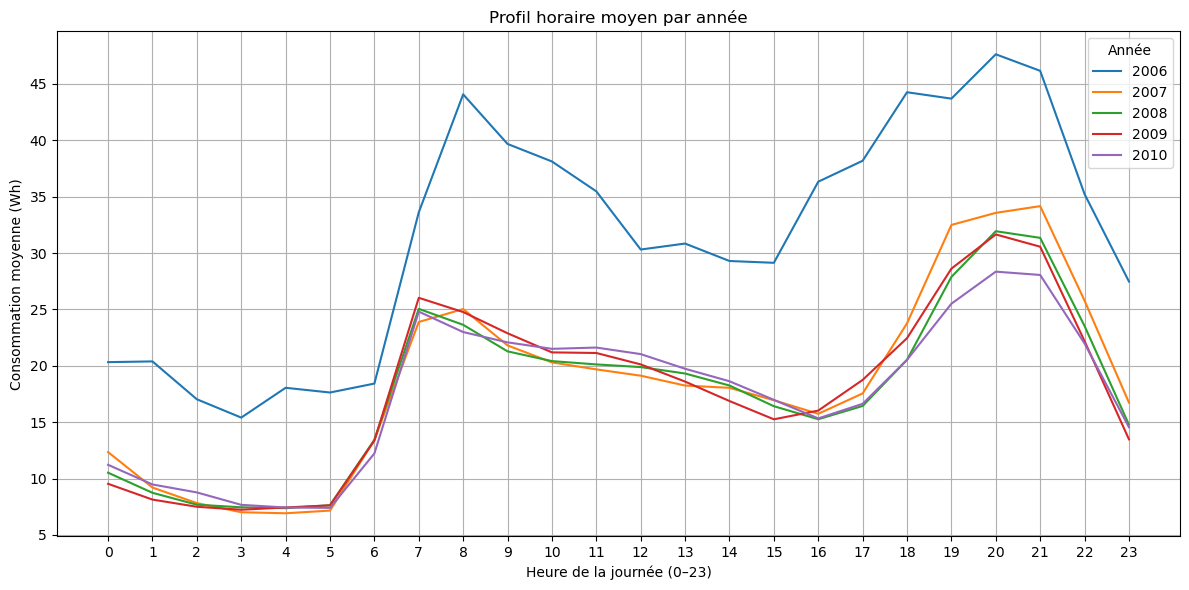

In [22]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                dayfirst=True)

df = df.dropna(subset=['DateTime'])

df = df.set_index('DateTime')

liste_annees = sorted(df.index.year.dropna().astype(int).unique())

plt.figure(figsize=(12,6))

for annee in liste_annees:
    df_year = df[df.index.year == annee]

    moyenne_par_heure = df_year['Global_active_power_wh'].groupby(
        df_year.index.hour
    ).mean()

    plt.plot(
        moyenne_par_heure.index, 
        moyenne_par_heure.values, 
        label=str(annee)
    )
    
plt.xlabel("Heure de la journée (0–23)")
plt.ylabel("Consommation moyenne (Wh)")
plt.title("Profil horaire moyen par année")
plt.grid(True)
plt.xticks(range(24))
plt.legend(title="Année")
plt.tight_layout()
plt.show()

#### Observations principales :

* Pointe matinale : on remarque un pic de consommation autour de 7-8h pour toutes les années, ce qui correspond probablement au moment où les gens se réveillent et utilisent l’électricité pour le petit-déjeuner, l’éclairage, etc.

* En 2006, ce pic est beaucoup plus marqué que pour les autres années.

* Heures creuses : entre 1h et 5h du matin, la consommation est la plus basse pour toutes les années, ce qui correspond aux heures de sommeil.

* Pic du soir : entre 19h et 21h, on observe un second pic, correspondant aux activités en soirée (cuisiner, éclairage, télévision…).

* En 2006, ce pic est aussi beaucoup plus élevé que les autres années.

### CONSOMMATION MENSUELLE MOYENNE PAR ANNEE  

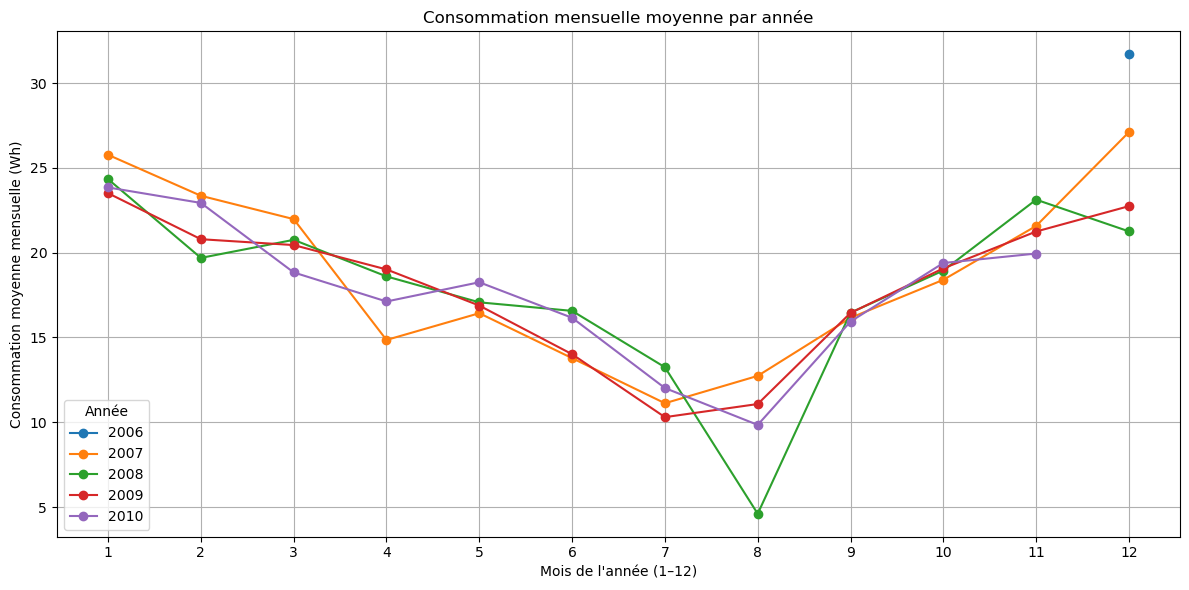

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                dayfirst=True, errors='coerce')

df = df.dropna(subset=['DateTime'])

df = df.set_index('DateTime')

liste_annees = sorted(df.index.year.dropna().astype(int).unique())

plt.figure(figsize=(12,6))

for annee in liste_annees:
    df_year = df[df.index.year == annee]

    moyenne_par_mois = df_year['Global_active_power_wh'].groupby(
        df_year.index.month
    ).mean()

    plt.plot(
        moyenne_par_mois.index, 
        moyenne_par_mois.values, 
        marker='o',
        label=str(annee)
    )

plt.xlabel("Mois de l'année (1–12)")
plt.ylabel("Consommation moyenne mensuelle (Wh)")
plt.title("Consommation mensuelle moyenne par année")
plt.grid(True)
plt.xticks(range(1,13))
plt.legend(title="Année")
plt.tight_layout()
plt.show()

#### Toutes les années suivent le même schéma général
* Hiver = forte consommation Été = faible consommation 
* C’est parfaitement normal : plus de chauffage plus d’éclairage plus d’appareils en fonctionnement durant les mois froids moins d’utilisation en été (absence, moins de chauffage, moins de lumière) 
*  forme en U est logique.


#### Minimum annuel : Juillet – Août

* Pour toutes les années, la consommation chute fortement entre juin → août.

* Cette chute est beaucoup plus importante en 2008

#### Analyse mois par mois 
* Janvier–Mars : très haute consommation pour toutes les années (froid).

* Avril–Juin : baisse progressive, assez stable d’une année à l’autre.

* Juillet–Août : creux important, signe :
--> soit d’absence
--> soit moins de chauffage
--> soit moins de chauffe-eau (si solaire / moins de douches chaudes)
--> soit données manquantes pour 2008

* Septembre–Décembre : remontée progressive vers les pics d’hiver.

### Consommation quotidienne par année

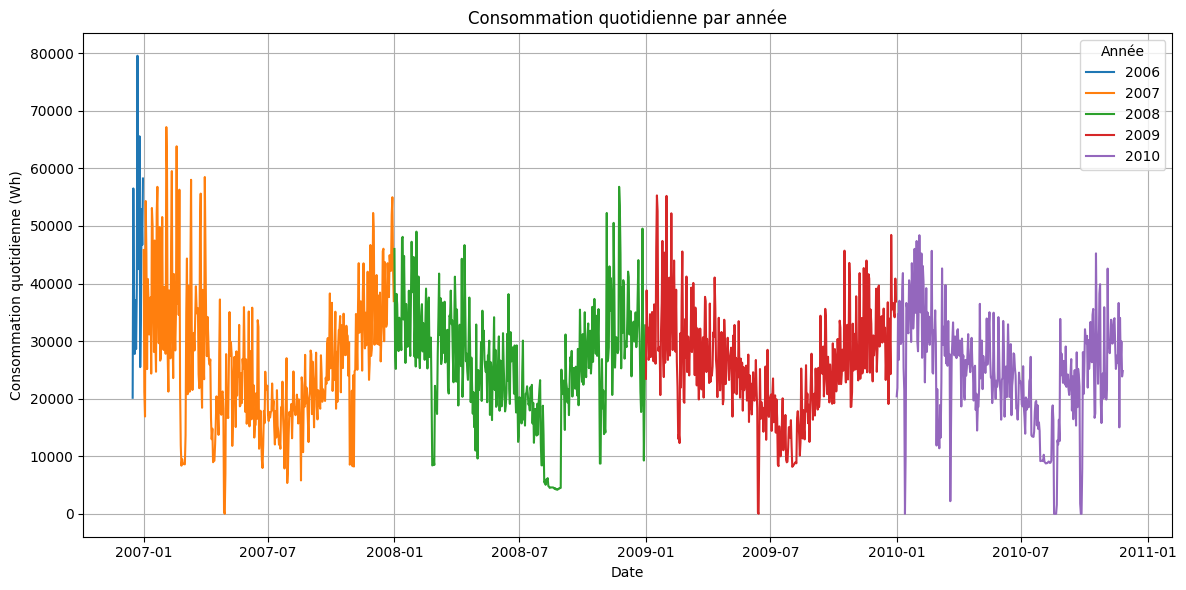

In [1188]:
import pandas as pd
import matplotlib.pyplot as plt

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                dayfirst=True, errors='coerce')


df = df.dropna(subset=['DateTime'])


df = df.set_index('DateTime')

liste_annees = sorted(df.index.year.dropna().astype(int).unique())

plt.figure(figsize=(12,6))

for annee in liste_annees:
    df_year = df[df.index.year == annee]

    consommation_quotidienne = df_year['Global_active_power_wh'].resample('D').sum()

    plt.plot(
        consommation_quotidienne.index, 
        consommation_quotidienne.values, 
        label=str(annee)
    )

plt.xlabel("Date")
plt.ylabel("Consommation quotidienne (Wh)")
plt.title("Consommation quotidienne par année")
plt.grid(True)
plt.legend(title="Année")
plt.tight_layout()
plt.show()

### VARIABLE DERIVEE
#### Comprendre la répartition de la consommation

* Sub_metering_1 = Cuisine

* Sub_metering_2 = Buanderie

* Sub_metering_3 = Chauffe-eau

* Global_active_power_wh = consommation totale de la maison

Tout ce qui n’est pas capturé par les trois sous-compteurs correspond à d’autres appareils électriques (TV, PC, éclairage, etc.).

autre_consommation permet donc de voir la part restante de la consommation totale qui n’est pas mesurée par les sous-compteurs.

In [27]:
df['autre_consommation'] = df['Global_active_power_wh'] - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
)

df['autre_consommation'] = df['autre_consommation'].clip(lower=0)


In [1190]:
df.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_wh,autre_consommation
DateTime,,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,70.266667,52.266667
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,89.333333,72.333333
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,89.566667,70.566667
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,89.800000,71.800000
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,61.100000,43.100000


Avec les autres consommations qu'on obtenu on pourra faire une analyse des diffrentes repartions par zone.

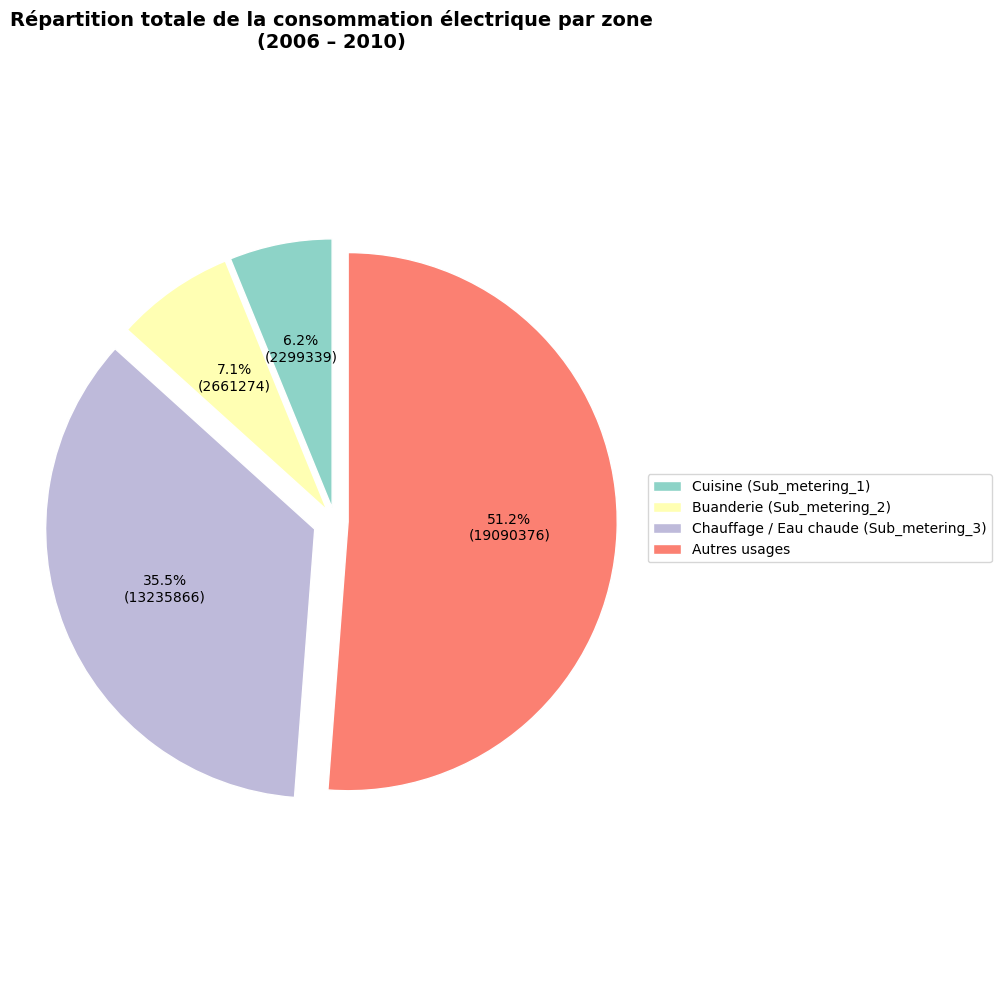

In [36]:
import matplotlib.pyplot as plt

# Données
zones_total = df[['Sub_metering_1',
                  'Sub_metering_2',
                  'Sub_metering_3',
                  'autre_consommation']].sum()

labels = [
    'Cuisine (Sub_metering_1)',
    'Buanderie (Sub_metering_2)',
    'Chauffage / Eau chaude (Sub_metering_3)',
    'Autres usages'
]

colors = plt.cm.Set3.colors[:4]  # palette harmonieuse

# Création du graphique
plt.figure(figsize=(10,10))

plt.pie(
    zones_total,
    labels=None,  # labels retirés pour légende externe
    autopct=lambda p: f'{p:.1f}%\n({int(p/100.*sum(zones_total))})',
    startangle=90,
    explode=[0.05, 0.05, 0.08, 0.05],
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)

plt.title(
    "Répartition totale de la consommation électrique par zone\n(2006 – 2010)",
    fontsize=14,
    fontweight='bold'
)

plt.axis('equal')  # cercle parfait
plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


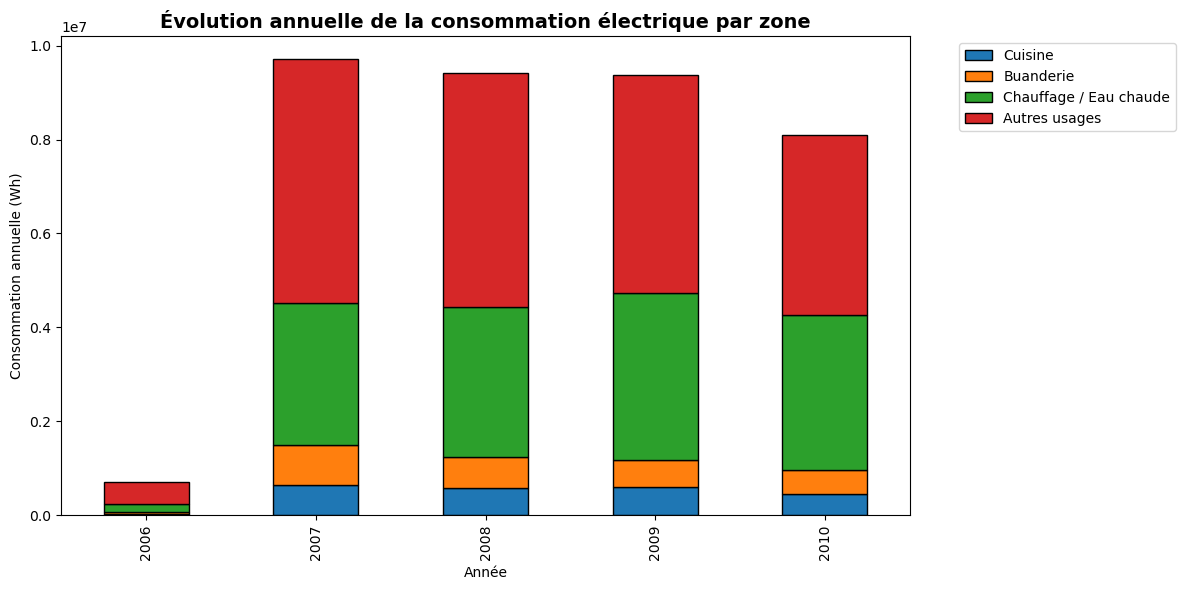

In [37]:
import matplotlib.pyplot as plt

zone_year.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    edgecolor='black'
)

plt.title(
    "Évolution annuelle de la consommation électrique par zone",
    fontsize=14,
    fontweight='bold'
)
plt.xlabel("Année")
plt.ylabel("Consommation annuelle (Wh)")
plt.legend(
    ['Cuisine','Buanderie','Chauffage / Eau chaude','Autres usages'],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


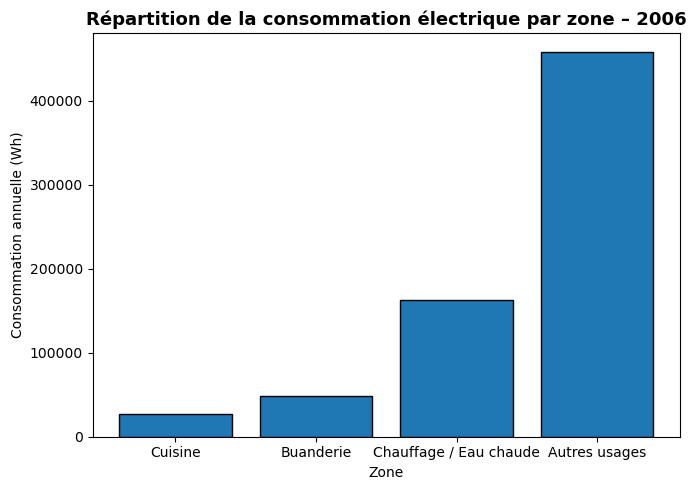

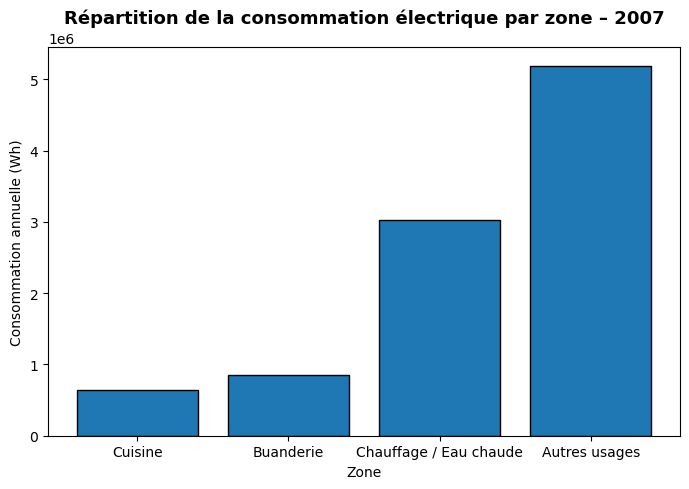

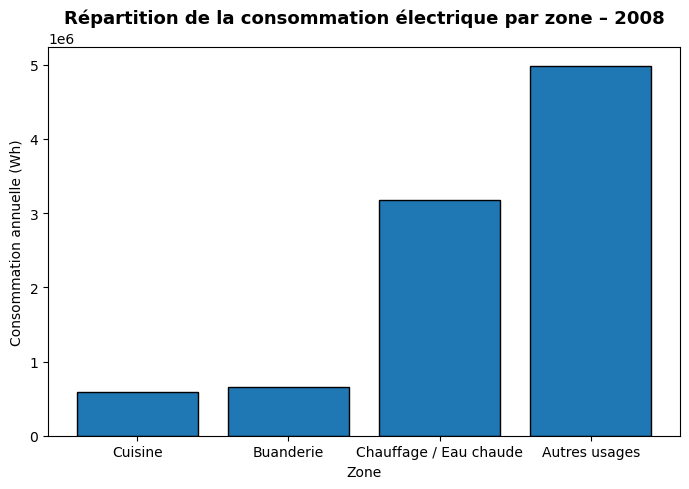

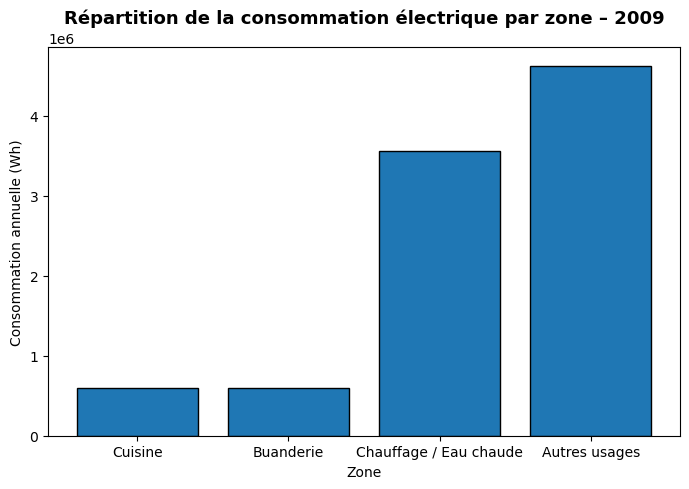

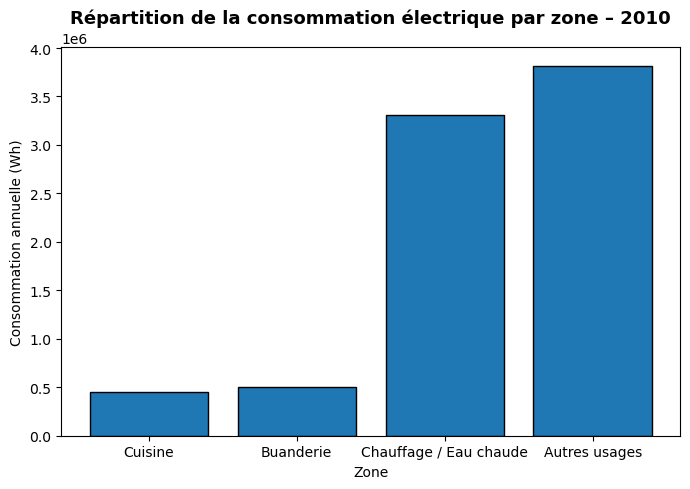

In [38]:
import matplotlib.pyplot as plt

zones = [
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'autre_consommation'
]

labels = [
    'Cuisine',
    'Buanderie',
    'Chauffage / Eau chaude',
    'Autres usages'
]

years = zone_year.index

for year in years:
    data = zone_year.loc[year]

    plt.figure(figsize=(7,5))
    
    plt.bar(
        labels,
        data,
        edgecolor='black'
    )
    
    plt.title(
        f"Répartition de la consommation électrique par zone – {year}",
        fontsize=13,
        fontweight='bold'
    )
    plt.ylabel("Consommation annuelle (Wh)")
    plt.xlabel("Zone")
    
    plt.tight_layout()
    plt.show()


In [45]:
# Assurer que l'index est bien en datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# Extraire année et mois
df['year'] = df.index.year
df['month'] = df.index.month

# Agréger par mois et année
zone_month = (
    df.groupby(['year','month'])[['Sub_metering_1','Sub_metering_2','Sub_metering_3','autre_consommation']]
    .sum()
    .reset_index()
)


In [50]:
# Sauvegarde du dataset complet 
df.to_csv("consommation_complete.csv", index=True)
